# 2010 Baja CA EQ, QTM Catalog Mapping: β-statistic grid, AFTER
### M >= 1.0
### 3/25/21
### Updated 4/2/21

In [1]:
# IMPORT CELL; updated 2/11/21

import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore') 
from importlib import reload
import time
import math
import scipy.stats as stats

import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

import obspy
from obspy.core import UTCDateTime
from obspy import read

import obspy.geodetics as gd # Imported whole file
#from obspy.geodetics import locations2degrees # calc_dist() alike?
#from obspy.taup.taup_geo import calc_dist # calc_dist()

import cartopy
import cartopy.crs as ccrs
from cartopy import config
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy import feature as cfeature
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE, OCEAN, LAKES, BORDERS
import matplotlib.ticker as mticker

print("Imported!")

Imported!


In [2]:
%%time
QTM_Range = pd.read_pickle("QTM_Range.pkl")
QTM_Range = QTM_Range.loc[QTM_Range['MAGNITUDE'] >= 1.0]
QTM_Range.describe()

Wall time: 1.03 s


YEAR         MONTH           DAY          HOUR        MINUTE  \
count  25071.0  25071.000000  25071.000000  25071.000000  25071.000000   
mean    2010.0      4.005983     12.849228     11.123210     29.423437   
std        0.0      0.306628      7.539287      6.877509     17.317354   
min     2010.0      3.000000      1.000000      0.000000      0.000000   
25%     2010.0      4.000000      7.000000      5.000000     14.000000   
50%     2010.0      4.000000     11.000000     11.000000     29.000000   
75%     2010.0      4.000000     18.000000     17.000000     44.000000   
max     2010.0      5.000000     31.000000     23.000000     59.000000   

             SECOND      LATITUDE     LONGITUDE         DEPTH     MAGNITUDE  \
count  25071.000000  25071.000000  25071.000000  25071.000000  25071.000000   
mean      29.871803     32.761895   -115.848034      7.851294      1.670261   
std       17.267331      0.587316      0.578823      4.104464      0.606847   
min        0.010000     31.916670   -121.569000     -1.001000      1.000000   
25%       14.810000     32.591815   -115.839260      4.917500      1.200000   
50%       29.750000     32.661300   -115.766290      7.807000      1.500000   
75%       44.753000     32.700040   -115.656690     10.033000      2.000000   
max       59.991000     36.780670   -114.810330     43.980000      7.200000   

          TIMESTAMP    VTIMESTAMP  RELATIVE DAY  RELATIVE HOUR  
count  2.507100e+04  2.507100e+04  25071.000000   25071.000000  
mean   1.271157e+09  1.271157e+09      8.513821     204.576642  
std    8.702312e+05  8.702312e+05     10.089166     241.724659  
min    1.267831e+09  1.267831e+09    -30.000000    -719.000000  
25%    1.270632e+09  1.270632e+09      2.000000      59.000000  
50%    1.270978e+09  1.270978e+09      6.000000     155.000000  
75%    1.271712e+09  1.271712e+09     15.000000     359.000000  
max    1.273013e+09  1.273013e+09     30.000000     720.000000

In [3]:
# Set mean latitudes and longitudes
MeanLat = QTM_Range["LATITUDE"].mean()
MeanLon = QTM_Range["LONGITUDE"].mean() 

# Define two more datasets of 30 days before and 30 days after Baja EQ
QTM_TEMP = QTM_Range.loc[QTM_Range["EVENTID"] == ""] # Get Baja EQ
QTM_TEMP = QTM_TEMP.iloc[0]
BajaTimestamp = float(QTM_TEMP["TIMESTAMP"])
BajaTimestamp

1270420842.0

In [4]:
QTM_Range_BEFORE = QTM_Range.loc[QTM_Range["TIMESTAMP"] <= BajaTimestamp]
QTM_Range_AFTER = QTM_Range.loc[QTM_Range["TIMESTAMP"] >= BajaTimestamp]

QTM_Range_BEFORE.describe()
QTM_Range_AFTER

YEAR  MONTH  DAY  HOUR  MINUTE  SECOND   EVENTID  LATITUDE  LONGITUDE  \
356879  2010      4    4    22      40  42.000            32.28600 -115.29500   
356879  2010      4    4    22      40  42.000            32.28600 -115.29500   
356880  2010      4    4    22      40  42.160  14607652  32.27350 -115.29400   
356881  2010      4    4    22      41  45.870    347184  34.43929 -116.93557   
356883  2010      4    4    22      42   7.710    347186  33.17864 -115.61955   
...      ...    ...  ...   ...     ...     ...       ...       ...        ...   
479959  2010      5    4    22      28  10.387  14693548  32.70310 -116.02574   
479961  2010      5    4    22      28  23.050    465015  32.98535 -115.58214   
479970  2010      5    4    22      32  30.153  14693564  33.92484 -117.83583   
479972  2010      5    4    22      34  42.330  14693572  32.22300 -115.27750   
479973  2010      5    4    22      35  48.290  14693580  32.20351 -115.25989   

         DEPTH  ...  TEMPLATEID STACKCC    MAD RELOCATED?  \
356879  10.000  ...                                         
356879  10.000  ...                                         
356880  13.990  ...    14607652     1.0   0.01          0   
356881  -0.583  ...     9807541   0.264  0.026          0   
356883   1.762  ...    11050669   0.251  0.018          0   
...        ...  ...         ...     ...    ...        ...   
479959  10.285  ...    14693548     1.0   0.01          1   
479961   8.841  ...    15199801   0.195   0.02          0   
479970   6.735  ...    14693564     1.0   0.01          1   
479972   8.680  ...    14693572     1.0   0.01          0   
479973   3.764  ...    14693580     1.0   0.01          1   

                         POSIX TIME     TIMESTAMP  \
356879  2010-04-04T22:40:42.000000Z  1.270421e+09   
356879  2010-04-04T22:40:42.000000Z  1.270421e+09   
356880  2010-04-04T22:40:42.160000Z  1.270421e+09   
356881  2010-04-04T22:41:45.870000Z  1.270421e+09   
356883  2010-04-04T22:42:07.710000Z  1.270421e+09   
...                             ...           ...   
479959  2010-05-04T22:28:10.387000Z  1.273012e+09   
479961  2010-05-04T22:28:23.050000Z  1.273012e+09   
479970  2010-05-04T22:32:30.153000Z  1.273012e+09   
479972  2010-05-04T22:34:42.330000Z  1.273012e+09   
479973  2010-05-04T22:35:48.290000Z  1.273013e+09   

                      VECTORIZATION    VTIMESTAMP  RELATIVE DAY RELATIVE HOUR  
356879  2010-04-04T22:40:42.000000Z  1.270421e+09           0.0           0.0  
356879  2010-04-04T22:40:42.000000Z  1.270421e+09           0.0           0.0  
356880  2010-04-04T22:40:42.159999Z  1.270421e+09           0.0           0.0  
356881  2010-04-04T22:41:45.869999Z  1.270421e+09           0.0           0.0  
356883  2010-04-04T22:42:07.710000Z  1.270421e+09           0.0           0.0  
...                             ...           ...           ...           ...  
479959  2010-05-04T22:28:10.387000Z  1.273012e+09          30.0         720.0  
479961  2010-05-04T22:28:23.050000Z  1.273012e+09          30.0         720.0  
479970  2010-05-04T22:32:30.152999Z  1.273012e+09          30.0         720.0  
479972  2010-05-04T22:34:42.329999Z  1.273012e+09          30.0         720.0  
479973  2010-05-04T22:35:48.289999Z  1.273013e+09          30.0         720.0  

[23790 rows x 23 columns]

In [5]:
QTM_Range["LONGITUDE"].values[0]
len(QTM_Range)
QTM_Range["LONGITUDE"].values

Faults = pd.read_csv("cafaults.xy", sep = "[\s]", names = ["LONGITUDE", "LATITUDE"])
# Read in fault traces
Faults
#Faults.describe()
#print(Faults.LATITUDE)
#Faults["LONGITUDE"].astype(float)
#Faults = Faults.loc[Faults["LONGITUDE"] == float]
#Faults.columns = ["LONGITUDE", "LATITUDE"]
#Faults
#Faults.LONGITUDE.astype(float)

FaultsIndices = list(Faults.loc[Faults["LONGITUDE"] == ">"].index)
#FaultsIndices

In [6]:
GridPoints = pd.read_csv("Maps/Density Grid/GridPoints.csv")

#### β = (Na - Λ)/√Λ
#### Λ = Nb * Δta/Δtb
Na = number of events during time period of interest delta time,a

Nb = total reference number of events during total reference time period delta time,b

3/23 edit: Nb should not be total # of events from entire subset, should be gridpoint specific too

### β-statistic grid: 2 hours after

In [7]:
0/np.sqrt(0)

nan

In [8]:
%%time

QTM_Range_After_2 = QTM_Range.loc[QTM_Range["TIMESTAMP"] >= BajaTimestamp]
QTM_Range_After_2 = QTM_Range_After_2.loc[QTM_Range_After_2["TIMESTAMP"] < BajaTimestamp + 2*60*60]

GridPoints["Beta_After_2"] = 0.0
for i in range(len(GridPoints)):
    TempDistsNa = pd.DataFrame(data = gd.locations2degrees(GridPoints.LATITUDE[i], GridPoints.LONGITUDE[i],
                            QTM_Range_After_2.LATITUDE, QTM_Range_After_2.LONGITUDE),
                            columns = ["DEGDIST"]) # Created DF of data w distances w respect to gridpoint i
    TempDistsNa = TempDistsNa.loc[TempDistsNa.DEGDIST <= 0.1] # Narrowed DF to within 0.1deg of gridpoint i
    NaTemp = len(TempDistsNa)
    
    TempDistsNb = pd.DataFrame(data = gd.locations2degrees(GridPoints.LATITUDE[i], GridPoints.LONGITUDE[i],
                              QTM_Range.LATITUDE, QTM_Range.LONGITUDE), columns = ["DEGDIST"])
    TempDistsNb = TempDistsNb.loc[TempDistsNb.DEGDIST <= 0.1]
    NbTemp = len(TempDistsNb)
    Lambda_After_2 = NbTemp*2/(60*24)
    
    BetaTemp = (NaTemp - Lambda_After_2)/np.sqrt(Lambda_After_2)
    GridPoints["Beta_After_2"][i] = BetaTemp
GridPoints.Beta_After_2 = GridPoints.Beta_After_2.fillna(0)

Wall time: 9.42 s


In [9]:
GridPoints.Beta_After_2.describe()
GridPoints.LATITUDE.max()

34.8

Wall time: 25.2 s


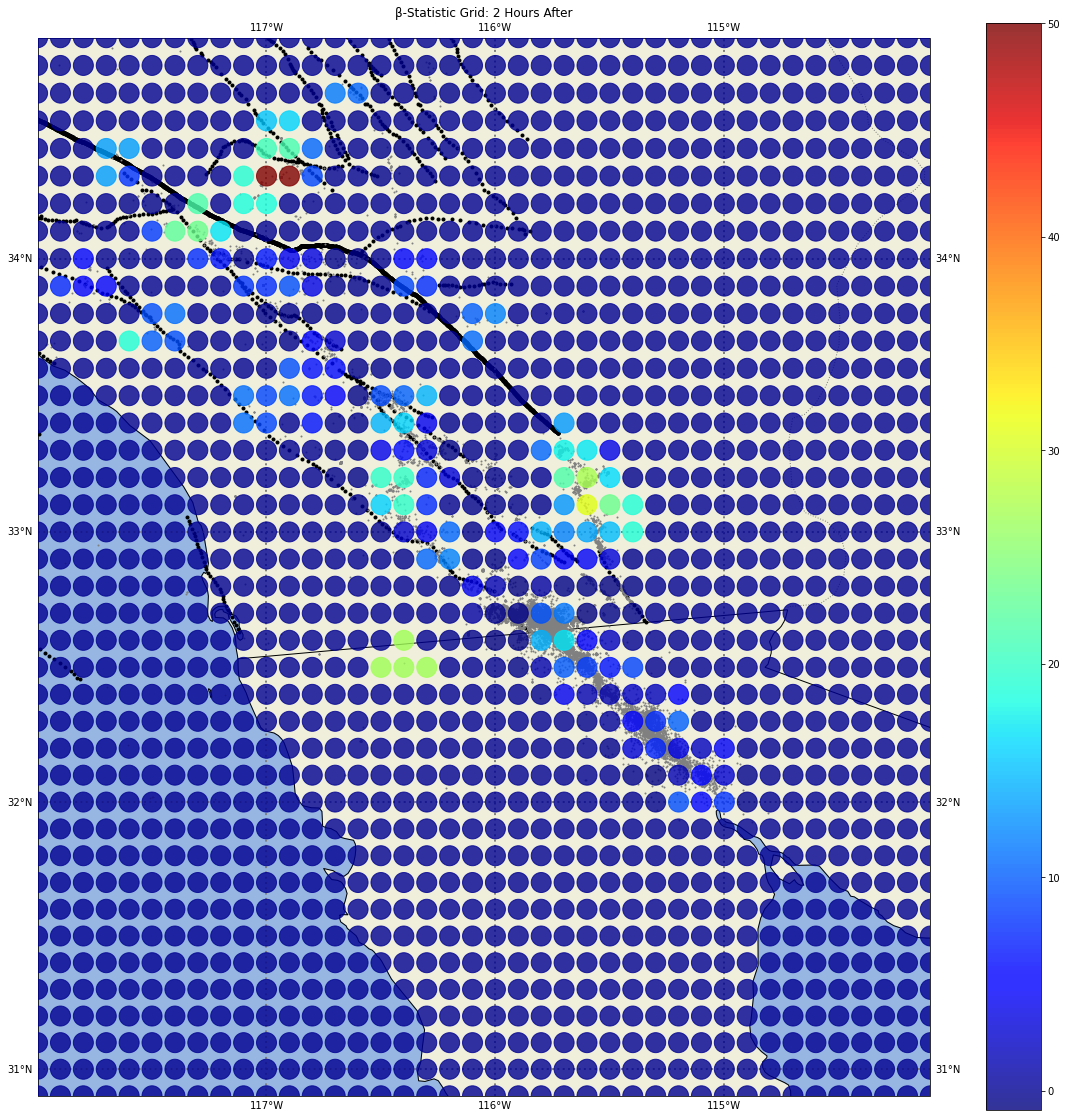

In [10]:
%%time
# Mapping: β-statistic grid - 2 hours after

proj = ccrs.Mercator(globe = None, latitude_true_scale = MeanLat)
fig = plt.figure(figsize = (20,20), frameon = True)
ax = plt.axes(projection = proj)
ax.set_extent([GridPoints.LONGITUDE.min(), GridPoints.LONGITUDE.max(), 
               GridPoints.LATITUDE.min(), GridPoints.LATITUDE.max()])
ax.add_feature(LAND);
ax.add_feature(OCEAN);
ax.coastlines(); # Put this line AFTER add_feature()s 
ax.add_feature(BORDERS,linestyle="-",linewidth=1); # Country border

states_provinces = cfeature.NaturalEarthFeature(category = "cultural", name = "admin_1_states_provinces_lines",
        scale = "50m", edgecolor = "grey", facecolor = "none", linestyle = "dotted")
ax.add_feature(states_provinces);

# ***GRIDLINES AND LABELS BLOCK***
gl=ax.gridlines(draw_labels = True, ylocs = np.arange(0, 90, 1), xlocs = np.arange(-180, 180, 1), 
                linewidth = 2, linestyle = "dotted", color = "grey")

# 60 days data
plt.plot(QTM_Range["LONGITUDE"].values, QTM_Range["LATITUDE"].values, 
        transform = ccrs.Geodetic(), marker = ".", color = "grey", 
        markersize = 2, linestyle = "None", zorder = 5);

# Plot fault traces
for i in range(len(FaultsIndices) - 1):
    minimum = FaultsIndices[i] + 1 
    maximum = FaultsIndices[i+1] 
    Temp = Faults.iloc[minimum:maximum].astype(float)
    plt.plot(Temp.LONGITUDE.values, Temp.LATITUDE.values, 
           transform = ccrs.Geodetic(), color = "black", 
            marker = ".", linestyle = "None", zorder = 1);

# Plot density gridpoints
plt.scatter(x = GridPoints.LONGITUDE, y = GridPoints.LATITUDE, transform = ccrs.PlateCarree(),
            c = GridPoints.Beta_After_2, cmap = mpl.cm.jet, 
            marker = "o", s = 400, alpha = 0.8, zorder = 10, vmax = 50)
plt.title("β-Statistic Grid: 2 Hours After");

plt.colorbar();
plt.savefig("Maps/β-Statistic Grid/After/Above 1.0/1_After_2H_2.png", facecolor = "white");

### β-statistic grid: 12 hours after

In [11]:
%%time

QTM_Range_After_12 = QTM_Range.loc[QTM_Range["TIMESTAMP"] >= BajaTimestamp]
QTM_Range_After_12 = QTM_Range_After_12.loc[QTM_Range_After_12["TIMESTAMP"] < BajaTimestamp + 12*60*60]

GridPoints["Beta_After_12"] = 0.0
for i in range(len(GridPoints)):
    TempDistsNa = pd.DataFrame(data = gd.locations2degrees(GridPoints.LATITUDE[i], GridPoints.LONGITUDE[i],
                            QTM_Range_After_12.LATITUDE, QTM_Range_After_12.LONGITUDE),
                            columns = ["DEGDIST"]) # Created DF of data w distances w respect to gridpoint i
    TempDistsNa = TempDistsNa.loc[TempDistsNa.DEGDIST <= 0.1] # Narrowed DF to within 0.1deg of gridpoint i
    NaTemp = len(TempDistsNa)
    
    TempDistsNb = pd.DataFrame(data = gd.locations2degrees(GridPoints.LATITUDE[i], GridPoints.LONGITUDE[i],
                              QTM_Range.LATITUDE, QTM_Range.LONGITUDE), columns = ["DEGDIST"])
    TempDistsNb = TempDistsNb.loc[TempDistsNb.DEGDIST <= 0.1]
    NbTemp = len(TempDistsNb)
    Lambda_After_12 = NbTemp*12/(60*24)
    
    BetaTemp = (NaTemp - Lambda_After_12)/np.sqrt(Lambda_After_12)
    GridPoints["Beta_After_12"][i] = BetaTemp
GridPoints.Beta_After_12 = GridPoints.Beta_After_12.fillna(0)

Wall time: 10 s


Wall time: 1.92 s


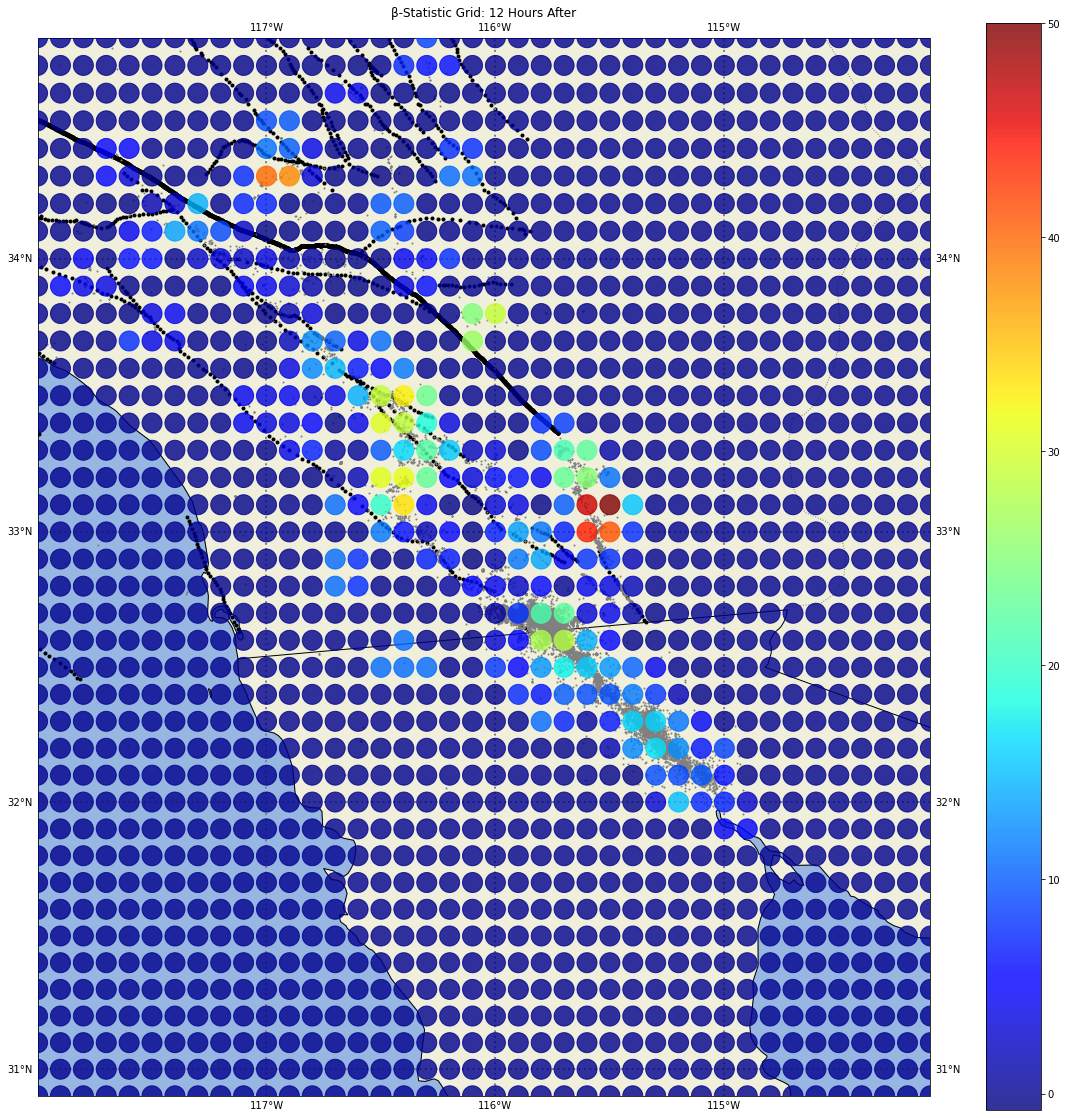

In [12]:
%%time
# Mapping: β-statistic grid - 12 hours after

proj = ccrs.Mercator(globe = None, latitude_true_scale = MeanLat)
fig = plt.figure(figsize = (20,20), frameon = True)
ax = plt.axes(projection = proj)
ax.set_extent([GridPoints.LONGITUDE.min(), GridPoints.LONGITUDE.max(), 
               GridPoints.LATITUDE.min(), GridPoints.LATITUDE.max()])
ax.add_feature(LAND);
ax.add_feature(OCEAN);
ax.coastlines(); # Put this line AFTER add_feature()s 
ax.add_feature(BORDERS,linestyle="-",linewidth=1); # Country border

states_provinces = cfeature.NaturalEarthFeature(category = "cultural", name = "admin_1_states_provinces_lines",
        scale = "50m", edgecolor = "grey", facecolor = "none", linestyle = "dotted")
ax.add_feature(states_provinces);

# ***GRIDLINES AND LABELS BLOCK***
gl=ax.gridlines(draw_labels = True, ylocs = np.arange(0, 90, 1), xlocs = np.arange(-180, 180, 1), 
                linewidth = 2, linestyle = "dotted", color = "grey")

# 60 days data
plt.plot(QTM_Range["LONGITUDE"].values, QTM_Range["LATITUDE"].values, 
        transform = ccrs.Geodetic(), marker = ".", color = "grey", 
        markersize = 2, linestyle = "None", zorder = 5);

# Plot fault traces
for i in range(len(FaultsIndices) - 1):
    minimum = FaultsIndices[i] + 1 
    maximum = FaultsIndices[i+1] 
    Temp = Faults.iloc[minimum:maximum].astype(float)
    plt.plot(Temp.LONGITUDE.values, Temp.LATITUDE.values, 
           transform = ccrs.Geodetic(), color = "black", 
            marker = ".", linestyle = "None", zorder = 1);

# Plot density gridpoints
plt.scatter(x = GridPoints.LONGITUDE, y = GridPoints.LATITUDE, transform = ccrs.PlateCarree(),
            c = GridPoints.Beta_After_12, cmap = mpl.cm.jet, 
            marker = "o", s = 400, alpha = 0.8, zorder = 10, vmax = 50)
plt.title("β-Statistic Grid: 12 Hours After");

plt.colorbar();
plt.savefig("Maps/β-Statistic Grid/After/Above 1.0/2_After_12H_2.png", facecolor = "white");

### β-statistic grid: 24 hours after

In [13]:
%%time

QTM_Range_After_24 = QTM_Range.loc[QTM_Range["TIMESTAMP"] >= BajaTimestamp]
QTM_Range_After_24 = QTM_Range_After_24.loc[QTM_Range_After_24["TIMESTAMP"] < BajaTimestamp + 24*60*60]

GridPoints["Beta_After_24"] = 0.0
for i in range(len(GridPoints)):
    TempDistsNa = pd.DataFrame(data = gd.locations2degrees(GridPoints.LATITUDE[i], GridPoints.LONGITUDE[i],
                            QTM_Range_After_24.LATITUDE, QTM_Range_After_24.LONGITUDE),
                            columns = ["DEGDIST"]) # Created DF of data w distances w respect to gridpoint i
    TempDistsNa = TempDistsNa.loc[TempDistsNa.DEGDIST <= 0.1] # Narrowed DF to within 0.1deg of gridpoint i
    NaTemp = len(TempDistsNa)
    
    TempDistsNb = pd.DataFrame(data = gd.locations2degrees(GridPoints.LATITUDE[i], GridPoints.LONGITUDE[i],
                              QTM_Range.LATITUDE, QTM_Range.LONGITUDE), columns = ["DEGDIST"])
    TempDistsNb = TempDistsNb.loc[TempDistsNb.DEGDIST <= 0.1]
    NbTemp = len(TempDistsNb)
    Lambda_After_24 = NbTemp*24/(60*24)
    
    BetaTemp = (NaTemp - Lambda_After_24)/np.sqrt(Lambda_After_24)
    GridPoints["Beta_After_24"][i] = BetaTemp
GridPoints.Beta_After_24 = GridPoints.Beta_After_24.fillna(0)

Wall time: 11.6 s


Wall time: 1.61 s


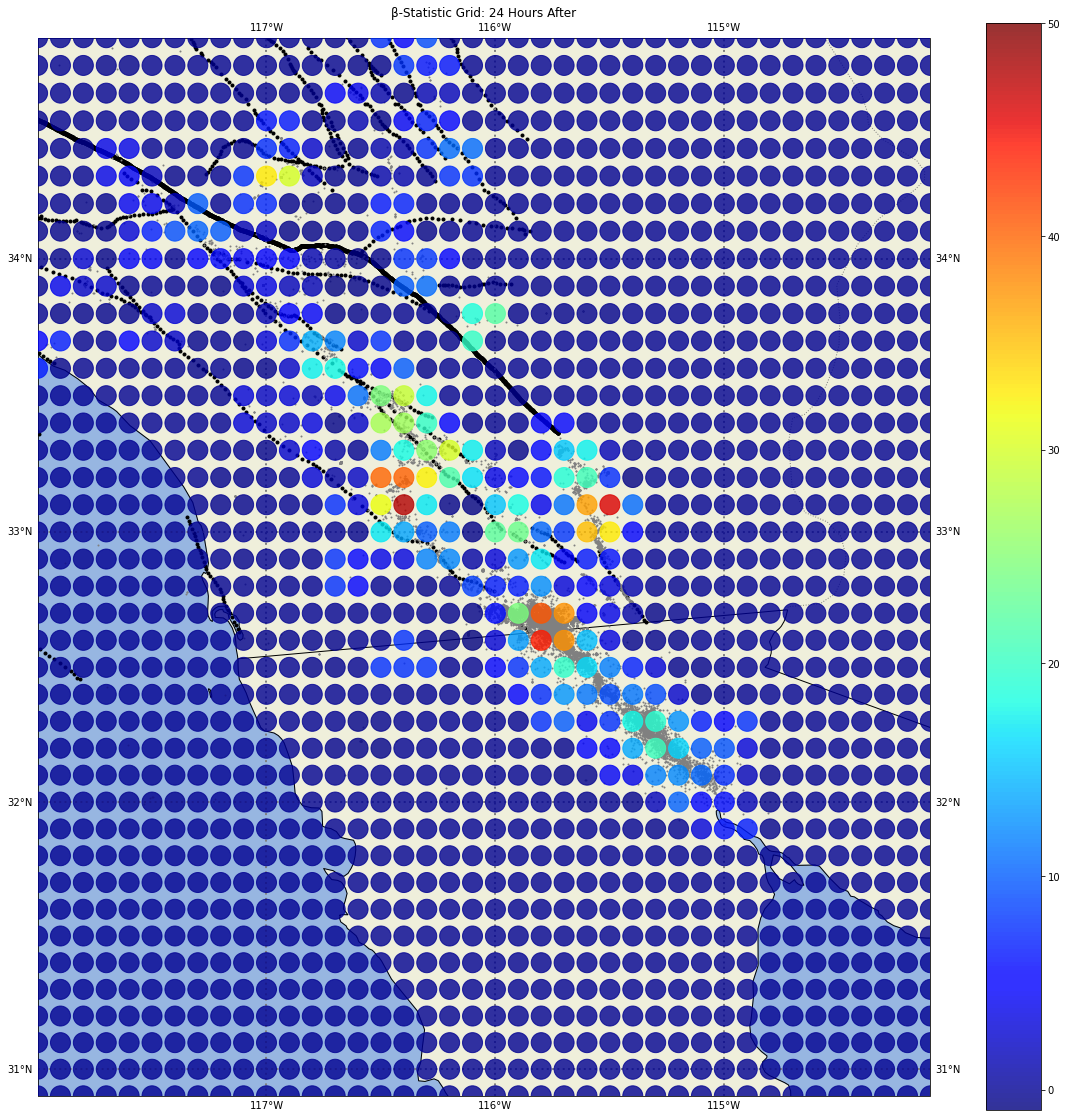

In [14]:
%%time
# Mapping: β-statistic grid - 24 hours after

proj = ccrs.Mercator(globe = None, latitude_true_scale = MeanLat)
fig = plt.figure(figsize = (20,20), frameon = True)
ax = plt.axes(projection = proj)
ax.set_extent([GridPoints.LONGITUDE.min(), GridPoints.LONGITUDE.max(), 
               GridPoints.LATITUDE.min(), GridPoints.LATITUDE.max()])
ax.add_feature(LAND);
ax.add_feature(OCEAN);
ax.coastlines(); # Put this line AFTER add_feature()s 
ax.add_feature(BORDERS,linestyle="-",linewidth=1); # Country border

states_provinces = cfeature.NaturalEarthFeature(category = "cultural", name = "admin_1_states_provinces_lines",
        scale = "50m", edgecolor = "grey", facecolor = "none", linestyle = "dotted")
ax.add_feature(states_provinces);

# ***GRIDLINES AND LABELS BLOCK***
gl=ax.gridlines(draw_labels = True, ylocs = np.arange(0, 90, 1), xlocs = np.arange(-180, 180, 1), 
                linewidth = 2, linestyle = "dotted", color = "grey")

# 60 days data
plt.plot(QTM_Range["LONGITUDE"].values, QTM_Range["LATITUDE"].values, 
        transform = ccrs.Geodetic(), marker = ".", color = "grey", 
        markersize = 2, linestyle = "None", zorder = 5);

# Plot fault traces
for i in range(len(FaultsIndices) - 1):
    minimum = FaultsIndices[i] + 1 
    maximum = FaultsIndices[i+1] 
    Temp = Faults.iloc[minimum:maximum].astype(float)
    plt.plot(Temp.LONGITUDE.values, Temp.LATITUDE.values, 
           transform = ccrs.Geodetic(), color = "black", 
            marker = ".", linestyle = "None", zorder = 1);

# Plot density gridpoints
plt.scatter(x = GridPoints.LONGITUDE, y = GridPoints.LATITUDE, transform = ccrs.PlateCarree(),
            c = GridPoints.Beta_After_24, cmap = mpl.cm.jet, 
            marker = "o", s = 400, alpha = 0.8, zorder = 10, vmax = 50)
plt.title("β-Statistic Grid: 24 Hours After");

plt.colorbar();
plt.savefig("Maps/β-Statistic Grid/After/Above 1.0/3_After_24H_2.png", facecolor = "white");

### β-statistic grid: 7 days after

In [15]:
%%time

QTM_Range_After_7D = QTM_Range.loc[QTM_Range["TIMESTAMP"] >= BajaTimestamp]
QTM_Range_After_7D = QTM_Range_After_7D.loc[QTM_Range_After_7D["TIMESTAMP"] < BajaTimestamp + 24*7*60*60]

GridPoints["Beta_After_7D"] = 0.0
for i in range(len(GridPoints)):
    TempDistsNa = pd.DataFrame(data = gd.locations2degrees(GridPoints.LATITUDE[i], GridPoints.LONGITUDE[i],
                            QTM_Range_After_7D.LATITUDE, QTM_Range_After_7D.LONGITUDE),
                            columns = ["DEGDIST"]) # Created DF of data w distances w respect to gridpoint i
    TempDistsNa = TempDistsNa.loc[TempDistsNa.DEGDIST <= 0.1] # Narrowed DF to within 0.1deg of gridpoint i
    NaTemp = len(TempDistsNa)
    
    TempDistsNb = pd.DataFrame(data = gd.locations2degrees(GridPoints.LATITUDE[i], GridPoints.LONGITUDE[i],
                              QTM_Range.LATITUDE, QTM_Range.LONGITUDE), columns = ["DEGDIST"])
    TempDistsNb = TempDistsNb.loc[TempDistsNb.DEGDIST <= 0.1]
    NbTemp = len(TempDistsNb)
    Lambda_After_7D = NbTemp*(24*7)/(60*24)
    
    BetaTemp = (NaTemp - Lambda_After_7D)/np.sqrt(Lambda_After_7D)
    GridPoints["Beta_After_7D"][i] = BetaTemp
GridPoints.Beta_After_7D = GridPoints.Beta_After_7D.fillna(0)

Wall time: 12.5 s


Wall time: 1.74 s


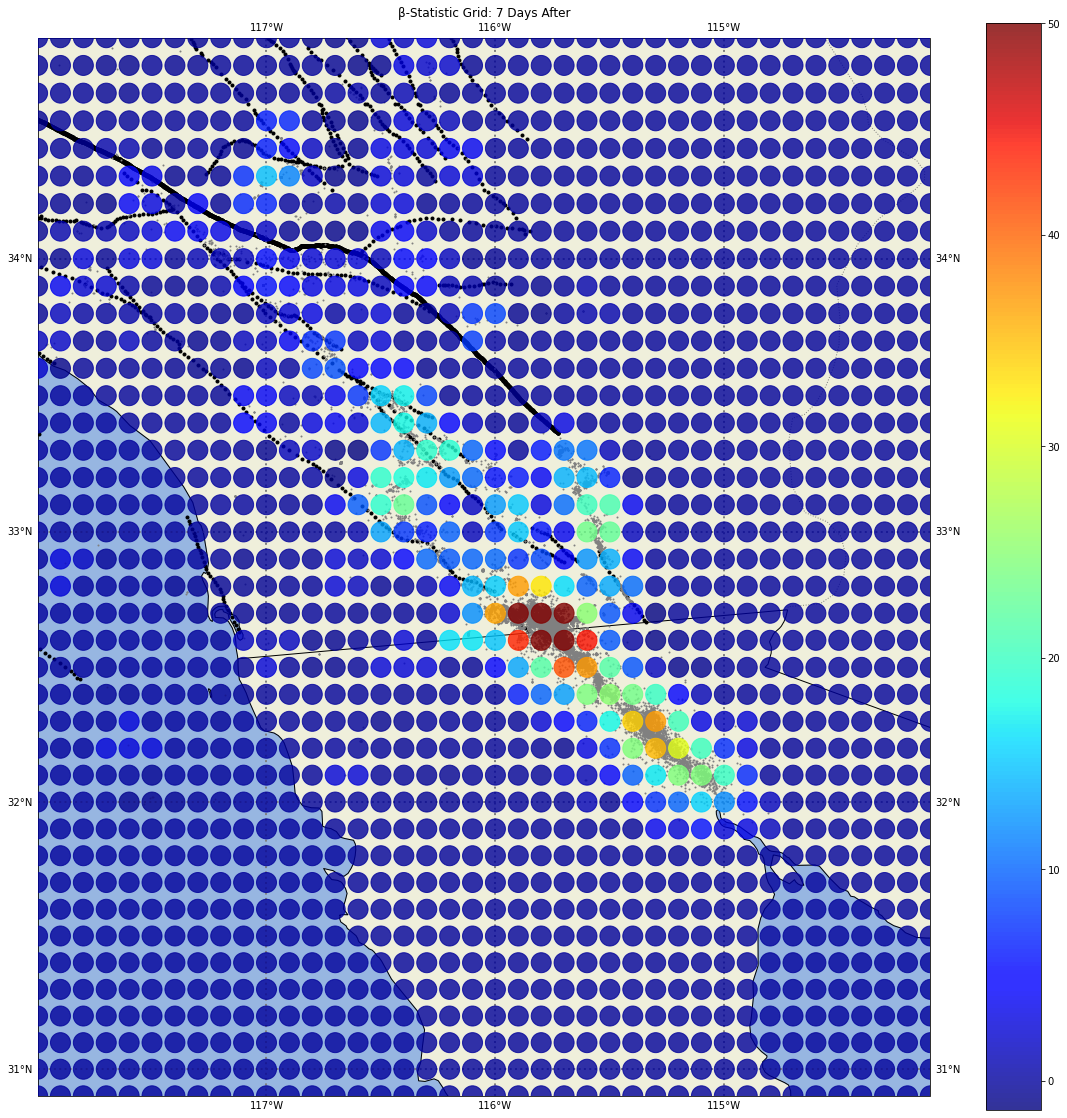

In [16]:
%%time
# Mapping: β-statistic grid - 7 days after

proj = ccrs.Mercator(globe = None, latitude_true_scale = MeanLat)
fig = plt.figure(figsize = (20,20), frameon = True)
ax = plt.axes(projection = proj)
ax.set_extent([GridPoints.LONGITUDE.min(), GridPoints.LONGITUDE.max(), 
               GridPoints.LATITUDE.min(), GridPoints.LATITUDE.max()])
ax.add_feature(LAND);
ax.add_feature(OCEAN);
ax.coastlines(); # Put this line AFTER add_feature()s 
ax.add_feature(BORDERS,linestyle="-",linewidth=1); # Country border

states_provinces = cfeature.NaturalEarthFeature(category = "cultural", name = "admin_1_states_provinces_lines",
        scale = "50m", edgecolor = "grey", facecolor = "none", linestyle = "dotted")
ax.add_feature(states_provinces);

# ***GRIDLINES AND LABELS BLOCK***
gl=ax.gridlines(draw_labels = True, ylocs = np.arange(0, 90, 1), xlocs = np.arange(-180, 180, 1), 
                linewidth = 2, linestyle = "dotted", color = "grey")

# 60 days data
plt.plot(QTM_Range["LONGITUDE"].values, QTM_Range["LATITUDE"].values, 
        transform = ccrs.Geodetic(), marker = ".", color = "grey", 
        markersize = 2, linestyle = "None", zorder = 5);

# Plot fault traces
for i in range(len(FaultsIndices) - 1):
    minimum = FaultsIndices[i] + 1 
    maximum = FaultsIndices[i+1] 
    Temp = Faults.iloc[minimum:maximum].astype(float)
    plt.plot(Temp.LONGITUDE.values, Temp.LATITUDE.values, 
           transform = ccrs.Geodetic(), color = "black", 
            marker = ".", linestyle = "None", zorder = 1);

# Plot density gridpoints
plt.scatter(x = GridPoints.LONGITUDE, y = GridPoints.LATITUDE, transform = ccrs.PlateCarree(),
            c = GridPoints.Beta_After_7D, cmap = mpl.cm.jet, 
            marker = "o", s = 400, alpha = 0.8, zorder = 10, vmax = 50)
plt.title("β-Statistic Grid: 7 Days After");

plt.colorbar();
plt.savefig("Maps/β-Statistic Grid/After/Above 1.0/4_After_7D_2.png", facecolor = "white");

### β-statistic grid: 10 days after

In [17]:
%%time

QTM_Range_After_10D = QTM_Range.loc[QTM_Range["TIMESTAMP"] >= BajaTimestamp]
QTM_Range_After_10D = QTM_Range_After_10D.loc[QTM_Range_After_10D["TIMESTAMP"] < BajaTimestamp + 24*10*60*60]

GridPoints["Beta_After_10D"] = 0.0
for i in range(len(GridPoints)):
    TempDistsNa = pd.DataFrame(data = gd.locations2degrees(GridPoints.LATITUDE[i], GridPoints.LONGITUDE[i],
                            QTM_Range_After_10D.LATITUDE, QTM_Range_After_10D.LONGITUDE),
                            columns = ["DEGDIST"]) # Created DF of data w distances w respect to gridpoint i
    TempDistsNa = TempDistsNa.loc[TempDistsNa.DEGDIST <= 0.1] # Narrowed DF to within 0.1deg of gridpoint i
    NaTemp = len(TempDistsNa)
    
    TempDistsNb = pd.DataFrame(data = gd.locations2degrees(GridPoints.LATITUDE[i], GridPoints.LONGITUDE[i],
                              QTM_Range.LATITUDE, QTM_Range.LONGITUDE), columns = ["DEGDIST"])
    TempDistsNb = TempDistsNb.loc[TempDistsNb.DEGDIST <= 0.1]
    NbTemp = len(TempDistsNb)
    Lambda_After_10D = NbTemp*(24*10)/(60*24)
    
    BetaTemp = (NaTemp - Lambda_After_10D)/np.sqrt(Lambda_After_10D)
    GridPoints["Beta_After_10D"][i] = BetaTemp
GridPoints.Beta_After_10D = GridPoints.Beta_After_10D.fillna(0)

Wall time: 12.8 s


Wall time: 1.73 s


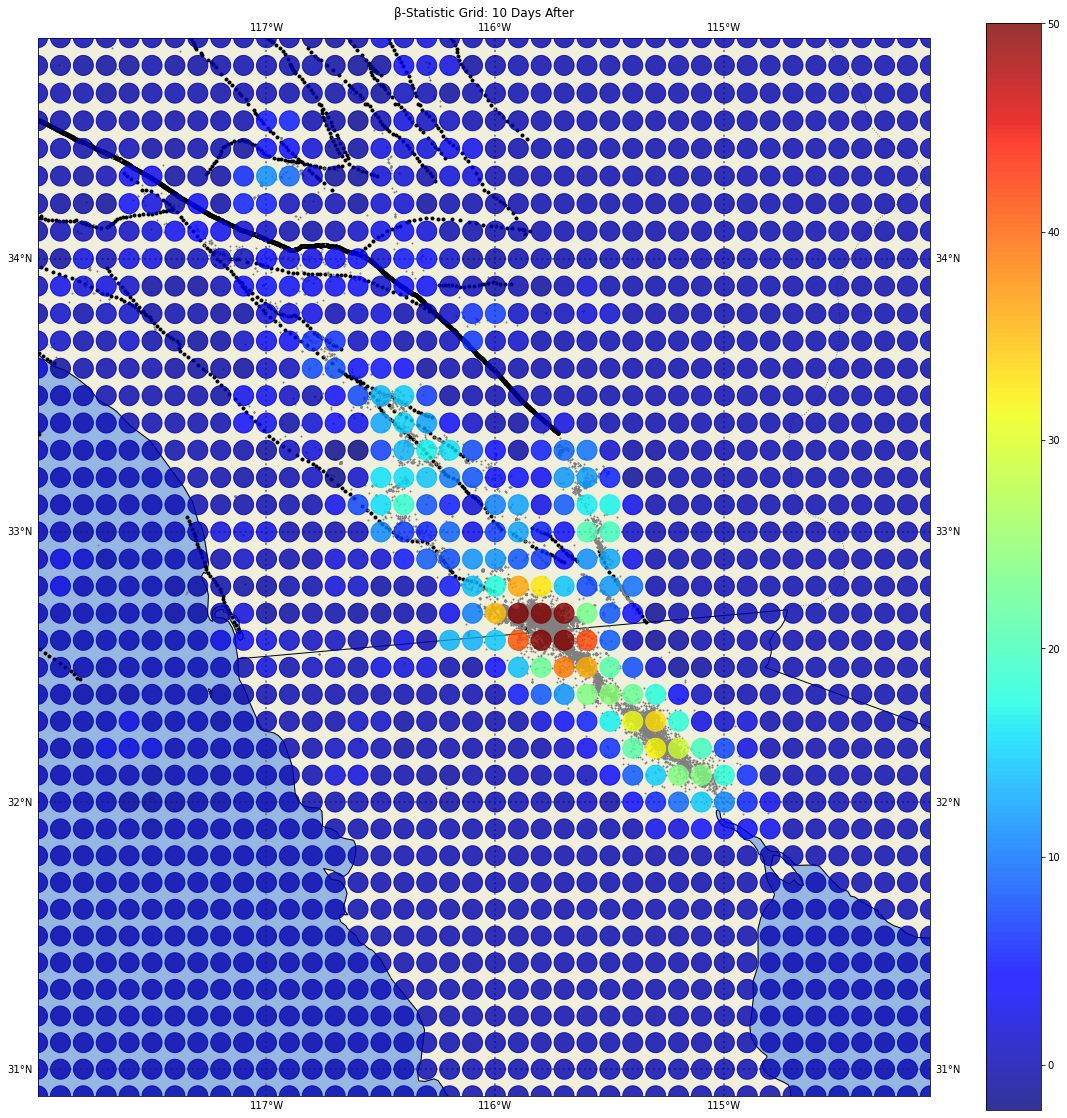

In [18]:
%%time
# Mapping: β-statistic grid - 10 days after

proj = ccrs.Mercator(globe = None, latitude_true_scale = MeanLat)
fig = plt.figure(figsize = (20,20), frameon = True)
ax = plt.axes(projection = proj)
ax.set_extent([GridPoints.LONGITUDE.min(), GridPoints.LONGITUDE.max(), 
               GridPoints.LATITUDE.min(), GridPoints.LATITUDE.max()])
ax.add_feature(LAND);
ax.add_feature(OCEAN);
ax.coastlines(); # Put this line AFTER add_feature()s 
ax.add_feature(BORDERS,linestyle="-",linewidth=1); # Country border

states_provinces = cfeature.NaturalEarthFeature(category = "cultural", name = "admin_1_states_provinces_lines",
        scale = "50m", edgecolor = "grey", facecolor = "none", linestyle = "dotted")
ax.add_feature(states_provinces);

# ***GRIDLINES AND LABELS BLOCK***
gl=ax.gridlines(draw_labels = True, ylocs = np.arange(0, 90, 1), xlocs = np.arange(-180, 180, 1), 
                linewidth = 2, linestyle = "dotted", color = "grey")

# 60 days data
plt.plot(QTM_Range["LONGITUDE"].values, QTM_Range["LATITUDE"].values, 
        transform = ccrs.Geodetic(), marker = ".", color = "grey", 
        markersize = 2, linestyle = "None", zorder = 5);

# Plot fault traces
for i in range(len(FaultsIndices) - 1):
    minimum = FaultsIndices[i] + 1 
    maximum = FaultsIndices[i+1] 
    Temp = Faults.iloc[minimum:maximum].astype(float)
    plt.plot(Temp.LONGITUDE.values, Temp.LATITUDE.values, 
           transform = ccrs.Geodetic(), color = "black", 
            marker = ".", linestyle = "None", zorder = 1);

# Plot density gridpoints
plt.scatter(x = GridPoints.LONGITUDE, y = GridPoints.LATITUDE, transform = ccrs.PlateCarree(),
            c = GridPoints.Beta_After_10D, cmap = mpl.cm.jet, 
            marker = "o", s = 400, alpha = 0.8, zorder = 10, vmax = 50)
plt.title("β-Statistic Grid: 10 Days After");

plt.colorbar();
plt.savefig("Maps/β-Statistic Grid/After/Above 1.0/5_After_10D_2.png", facecolor = "white");

### β-statistic grid: 20 days after

In [19]:
%%time

QTM_Range_After_20D = QTM_Range.loc[QTM_Range["TIMESTAMP"] >= BajaTimestamp]
QTM_Range_After_20D = QTM_Range_After_20D.loc[QTM_Range_After_20D["TIMESTAMP"] < BajaTimestamp + 24*20*60*60]

GridPoints["Beta_After_20D"] = 0.0
for i in range(len(GridPoints)):
    TempDistsNa = pd.DataFrame(data = gd.locations2degrees(GridPoints.LATITUDE[i], GridPoints.LONGITUDE[i],
                            QTM_Range_After_20D.LATITUDE, QTM_Range_After_20D.LONGITUDE),
                            columns = ["DEGDIST"]) # Created DF of data w distances w respect to gridpoint i
    TempDistsNa = TempDistsNa.loc[TempDistsNa.DEGDIST <= 0.1] # Narrowed DF to within 0.1deg of gridpoint i
    NaTemp = len(TempDistsNa)
    
    TempDistsNb = pd.DataFrame(data = gd.locations2degrees(GridPoints.LATITUDE[i], GridPoints.LONGITUDE[i],
                              QTM_Range.LATITUDE, QTM_Range.LONGITUDE), columns = ["DEGDIST"])
    TempDistsNb = TempDistsNb.loc[TempDistsNb.DEGDIST <= 0.1]
    NbTemp = len(TempDistsNb)
    Lambda_After_20D = NbTemp*(24*20)/(60*24)
    
    BetaTemp = (NaTemp - Lambda_After_20D)/np.sqrt(Lambda_After_20D)
    GridPoints["Beta_After_20D"][i] = BetaTemp
GridPoints.Beta_After_20D = GridPoints.Beta_After_20D.fillna(0)

Wall time: 12.5 s


Wall time: 1.64 s


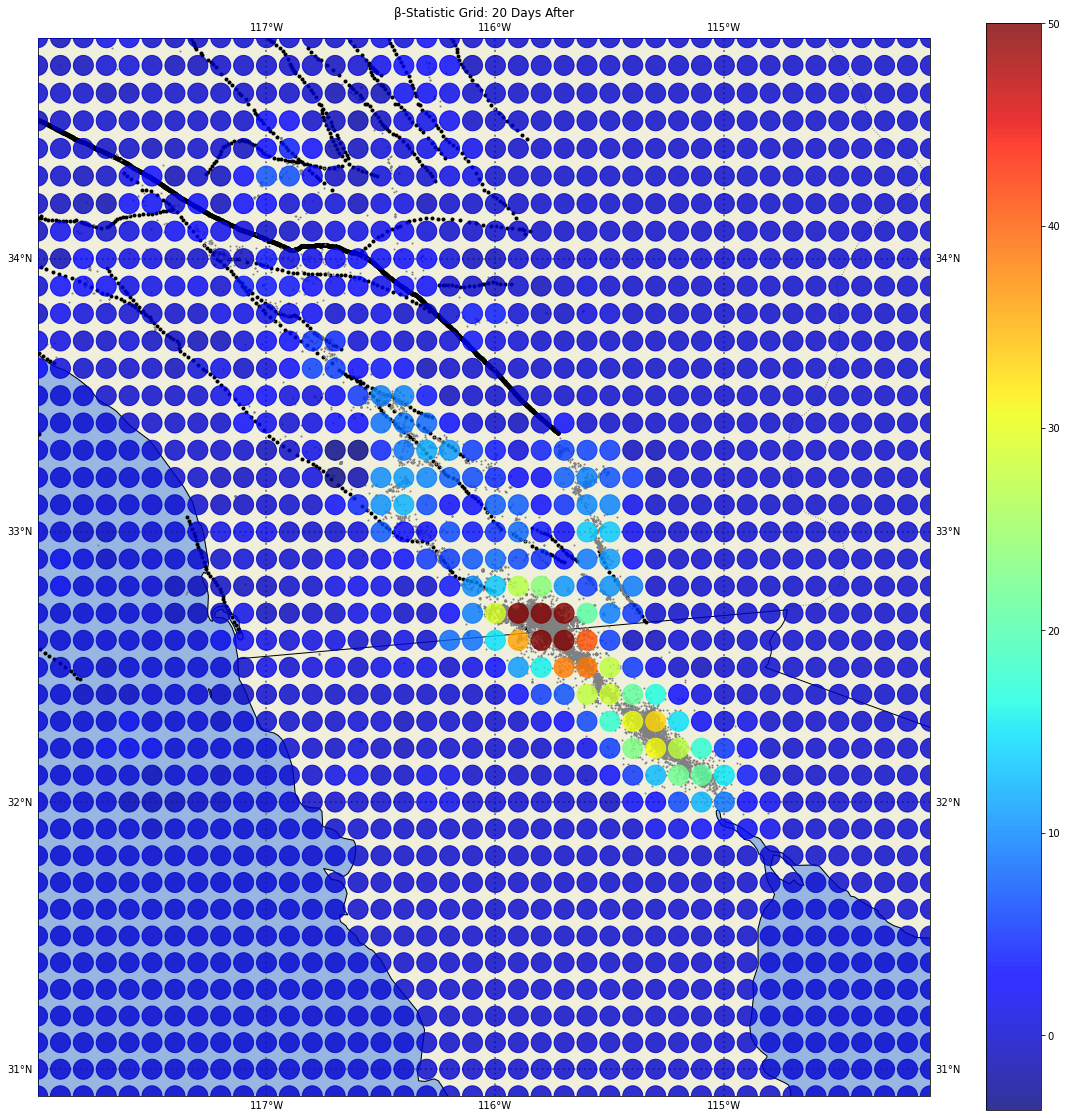

In [20]:
%%time
# Mapping: β-statistic grid - 20 days after

proj = ccrs.Mercator(globe = None, latitude_true_scale = MeanLat)
fig = plt.figure(figsize = (20,20), frameon = True)
ax = plt.axes(projection = proj)
ax.set_extent([GridPoints.LONGITUDE.min(), GridPoints.LONGITUDE.max(), 
               GridPoints.LATITUDE.min(), GridPoints.LATITUDE.max()])
ax.add_feature(LAND);
ax.add_feature(OCEAN);
ax.coastlines(); # Put this line AFTER add_feature()s 
ax.add_feature(BORDERS,linestyle="-",linewidth=1); # Country border

states_provinces = cfeature.NaturalEarthFeature(category = "cultural", name = "admin_1_states_provinces_lines",
        scale = "50m", edgecolor = "grey", facecolor = "none", linestyle = "dotted")
ax.add_feature(states_provinces);

# ***GRIDLINES AND LABELS BLOCK***
gl=ax.gridlines(draw_labels = True, ylocs = np.arange(0, 90, 1), xlocs = np.arange(-180, 180, 1), 
                linewidth = 2, linestyle = "dotted", color = "grey")

# 60 days data
plt.plot(QTM_Range["LONGITUDE"].values, QTM_Range["LATITUDE"].values, 
        transform = ccrs.Geodetic(), marker = ".", color = "grey", 
        markersize = 2, linestyle = "None", zorder = 5);

# Plot fault traces
for i in range(len(FaultsIndices) - 1):
    minimum = FaultsIndices[i] + 1 
    maximum = FaultsIndices[i+1] 
    Temp = Faults.iloc[minimum:maximum].astype(float)
    plt.plot(Temp.LONGITUDE.values, Temp.LATITUDE.values, 
           transform = ccrs.Geodetic(), color = "black", 
            marker = ".", linestyle = "None", zorder = 1);

# Plot density gridpoints
plt.scatter(x = GridPoints.LONGITUDE, y = GridPoints.LATITUDE, transform = ccrs.PlateCarree(),
            c = GridPoints.Beta_After_20D, cmap = mpl.cm.jet, 
            marker = "o", s = 400, alpha = 0.8, zorder = 20, vmax = 50)
plt.title("β-Statistic Grid: 20 Days After");

plt.colorbar();
plt.savefig("Maps/β-Statistic Grid/After/Above 1.0/6_After_20D_2.png", facecolor = "white");

### β-statistic grid: 30 days after

In [21]:
%%time

QTM_Range_After_30D = QTM_Range.loc[QTM_Range["TIMESTAMP"] >= BajaTimestamp]
QTM_Range_After_30D = QTM_Range_After_30D.loc[QTM_Range_After_30D["TIMESTAMP"] < BajaTimestamp + 24*30*60*60]

GridPoints["Beta_After_30D"] = 0.0
for i in range(len(GridPoints)):
    TempDistsNa = pd.DataFrame(data = gd.locations2degrees(GridPoints.LATITUDE[i], GridPoints.LONGITUDE[i],
                            QTM_Range_After_30D.LATITUDE, QTM_Range_After_30D.LONGITUDE),
                            columns = ["DEGDIST"]) # Created DF of data w distances w respect to gridpoint i
    TempDistsNa = TempDistsNa.loc[TempDistsNa.DEGDIST <= 0.1] # Narrowed DF to within 0.1deg of gridpoint i
    NaTemp = len(TempDistsNa)
    
    TempDistsNb = pd.DataFrame(data = gd.locations2degrees(GridPoints.LATITUDE[i], GridPoints.LONGITUDE[i],
                              QTM_Range.LATITUDE, QTM_Range.LONGITUDE), columns = ["DEGDIST"])
    TempDistsNb = TempDistsNb.loc[TempDistsNb.DEGDIST <= 0.1]
    NbTemp = len(TempDistsNb)
    Lambda_After_30D = NbTemp*(24*30)/(60*24)
    
    BetaTemp = (NaTemp - Lambda_After_30D)/np.sqrt(Lambda_After_30D)
    GridPoints["Beta_After_30D"][i] = BetaTemp
GridPoints.Beta_After_30D = GridPoints.Beta_After_30D.fillna(0)

Wall time: 13.9 s


Wall time: 2.55 s


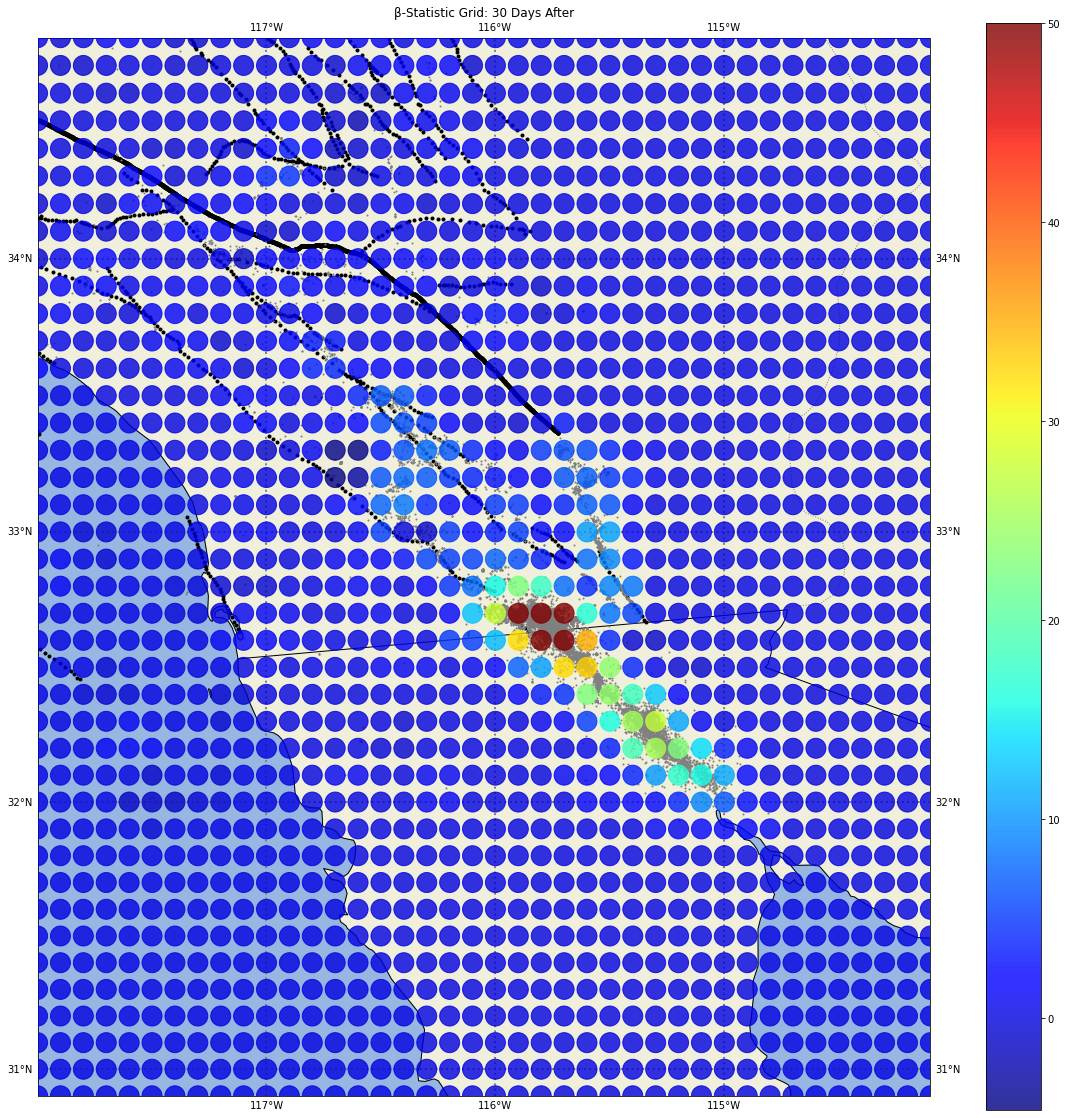

In [22]:
%%time
# Mapping: β-statistic grid - 30 days after

proj = ccrs.Mercator(globe = None, latitude_true_scale = MeanLat)
fig = plt.figure(figsize = (20,20), frameon = True)
ax = plt.axes(projection = proj)
ax.set_extent([GridPoints.LONGITUDE.min(), GridPoints.LONGITUDE.max(), 
               GridPoints.LATITUDE.min(), GridPoints.LATITUDE.max()])
ax.add_feature(LAND);
ax.add_feature(OCEAN);
ax.coastlines(); # Put this line AFTER add_feature()s 
ax.add_feature(BORDERS,linestyle="-",linewidth=1); # Country border

states_provinces = cfeature.NaturalEarthFeature(category = "cultural", name = "admin_1_states_provinces_lines",
        scale = "50m", edgecolor = "grey", facecolor = "none", linestyle = "dotted")
ax.add_feature(states_provinces);

# ***GRIDLINES AND LABELS BLOCK***
gl=ax.gridlines(draw_labels = True, ylocs = np.arange(0, 90, 1), xlocs = np.arange(-180, 180, 1), 
                linewidth = 2, linestyle = "dotted", color = "grey")

# 60 days data
plt.plot(QTM_Range["LONGITUDE"].values, QTM_Range["LATITUDE"].values, 
        transform = ccrs.Geodetic(), marker = ".", color = "grey", 
        markersize = 2, linestyle = "None", zorder = 5);

# Plot fault traces
for i in range(len(FaultsIndices) - 1):
    minimum = FaultsIndices[i] + 1 
    maximum = FaultsIndices[i+1] 
    Temp = Faults.iloc[minimum:maximum].astype(float)
    plt.plot(Temp.LONGITUDE.values, Temp.LATITUDE.values, 
           transform = ccrs.Geodetic(), color = "black", 
            marker = ".", linestyle = "None", zorder = 1);

# Plot density gridpoints
plt.scatter(x = GridPoints.LONGITUDE, y = GridPoints.LATITUDE, transform = ccrs.PlateCarree(),
            c = GridPoints.Beta_After_30D, cmap = mpl.cm.jet, 
            marker = "o", s = 400, alpha = 0.8, zorder = 10, vmax = 50)
plt.title("β-Statistic Grid: 30 Days After");

plt.colorbar();
plt.savefig("Maps/β-Statistic Grid/After/Above 1.0/7_After_30D_2.png", facecolor = "white");